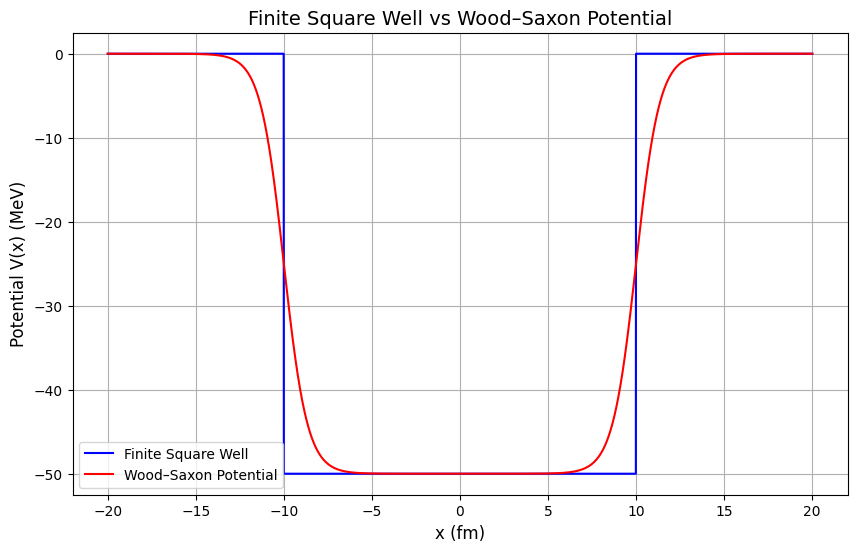

Symmetric Shooting – Numerical Eigenvalues for Finite Square Well (MeV):
n=1: E=-49.74 MeV
n=2: E=-48.98 MeV
n=3: E=-47.70 MeV
n=4: E=-48.98 MeV

Analytical Eigenvalues for Finite Square Well (MeV):
n=1: E=-49.77 MeV
n=2: E=-49.74 MeV
n=3: E=-47.89 MeV
n=4: E=-47.70 MeV

Numerical Eigenvalues for Wood–Saxon Potential (MeV):
n=1: E=-49.67 MeV
n=2: E=-48.70 MeV
n=3: E=-47.16 MeV
n=4: E=-45.09 MeV

WKB Approximation Eigenvalues for Wood–Saxon Potential (MeV):
n=1: E=-49.81 MeV
n=2: E=-48.85 MeV
n=3: E=-47.28 MeV
n=4: E=-45.18 MeV


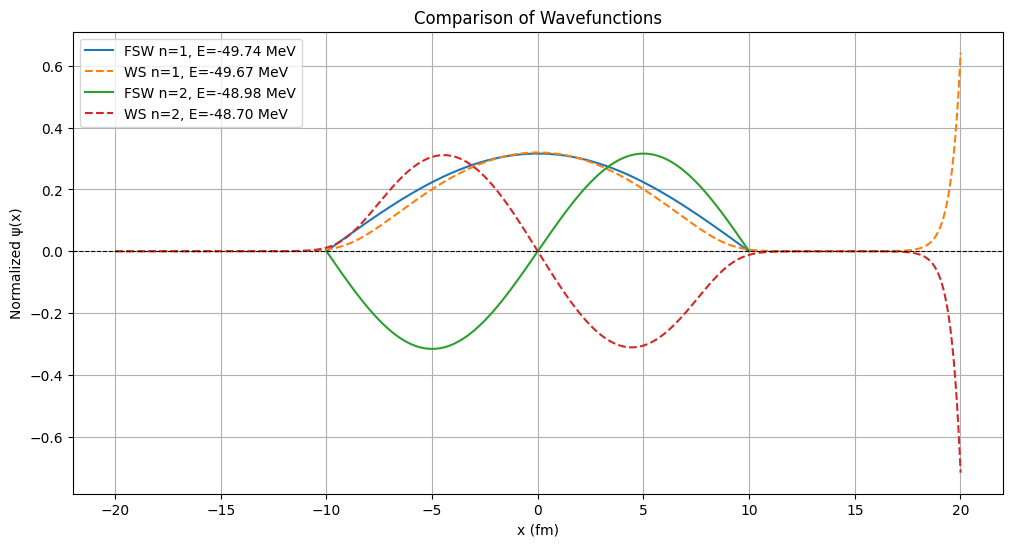

In [3]:
import numpy as np
from scipy.optimize import root_scalar, brentq
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# Constants and parameters
hbar2_over_2m = 20.75  # MeV·fm²
V0 = 50.0            # MeV (depth of the potential)
R = 10.0              # fm (half–width for the finite square well)
a0 = 0.67            # fm (diffuseness for Wood–Saxon potential)
h = 0.01             # fm, mesh size
tolerance = 1e-8     # energy convergence precision

# Potential functions
def V_fsw(x):
    return -V0 if abs(x) <= R else 0.0

def V_ws(x):
    return -V0 / (1 + np.exp((abs(x) - R) / a0))

# -------------------------------------------------------
# Analytical solution for FSW using transcendental equations
# -------------------------------------------------------
def even_condition(E):
    # Even parity: k tan(kR) = κ with k = sqrt(2(E+V0)/hbar2_over_2m)
    k = np.sqrt(2 * (E + V0) / hbar2_over_2m)
    kappa = np.sqrt(2 * (-E) / hbar2_over_2m)
    return k * np.tan(k * R) - kappa

def odd_condition(E):
    # Odd parity: k cot(kR) = -κ  i.e. k/ tan(kR) + κ = 0
    k = np.sqrt(2 * (E + V0) / hbar2_over_2m)
    kappa = np.sqrt(2 * (-E) / hbar2_over_2m)
    return k / np.tan(k * R) + kappa

def solve_transcendental(eq_func, E_start, E_end):
    solution = root_scalar(eq_func, bracket=[E_start, E_end], method='brentq')
    if solution.converged:
        return solution.root
    else:
        return None

# Search for 4 analytical eigenvalues (alternating even and odd)
energy_range = np.linspace(-V0, 0, 1000)
analytical_fsw_eigenvalues = []
for eq_func in [even_condition, odd_condition] * 2:  # alternate even/odd conditions
    for i in range(len(energy_range) - 1):
        E1, E2 = energy_range[i], energy_range[i+1]
        if eq_func(E1) * eq_func(E2) < 0:
            eigenvalue = solve_transcendental(eq_func, E1, E2)
            if eigenvalue is not None:
                analytical_fsw_eigenvalues.append(eigenvalue)
                if len(analytical_fsw_eigenvalues) == 4:
                    break
    if len(analytical_fsw_eigenvalues) == 4:
        break

# -------------------------------------------------------
# Updated symmetric shooting method for FSW
# -------------------------------------------------------
def numerov_shoot_sym(E, parity, x_grid, V_func):
    N = len(x_grid)
    psi = np.zeros(N)
    if parity == 'even':
        psi[0] = 1.0
        k0 = 2 * (E - V_func(0)) / hbar2_over_2m
        psi[1] = 1.0 - (h**2 / 2) * k0  # Taylor expansion for small h
    elif parity == 'odd':
        psi[0] = 0.0
        psi[1] = h   # arbitrary scaling (ψ'(0)=1)
    else:
        raise ValueError("Parity must be 'even' or 'odd'")
    k_array = np.array([2 * (E - V_func(x)) / hbar2_over_2m for x in x_grid])
    for i in range(1, N - 1):
        psi[i+1] = ((2 * (1 - (5 * h**2 / 12) * k_array[i]) * psi[i]
                     - (1 + (h**2 / 12) * k_array[i-1]) * psi[i-1])
                    / (1 + (h**2 / 12) * k_array[i+1]))
    return psi

def f_boundary_sym(E, parity, x_grid, V_func):
    psi = numerov_shoot_sym(E, parity, x_grid, V_func)
    return psi[-1]  # We require ψ(x_max) ≈ 0

def get_numerical_eigenvalue_sym(parity, E_guess, x_grid, V_func, delta=0.5):
    E_low = E_guess - delta
    E_high = E_guess + delta
    f_low = f_boundary_sym(E_low, parity, x_grid, V_func)
    f_high = f_boundary_sym(E_high, parity, x_grid, V_func)
    while f_low * f_high > 0:
        delta *= 1.5
        E_low = E_guess - delta
        E_high = E_guess + delta
        f_low = f_boundary_sym(E_low, parity, x_grid, V_func)
        f_high = f_boundary_sym(E_high, parity, x_grid, V_func)
    eigenvalue = brentq(lambda E: f_boundary_sym(E, parity, x_grid, V_func),
                        E_low, E_high, xtol=tolerance)
    return eigenvalue

# Compute numerical eigenvalues and full (symmetric) wavefunctions for FSW
n_levels = 4
fsw_num_eigenvalues = []
fsw_num_wavefunctions = []
x_max_sym = 10.0  # Integration domain for the symmetric method
x_grid_sym = np.arange(0, x_max_sym + h, h)
# Parity assignment: state 1 (even), 2 (odd), 3 (even), 4 (odd)
parity_list = ['even', 'odd', 'even', 'odd']
for i, parity in enumerate(parity_list):
    # Use the corresponding analytical eigenvalue as the initial guess
    E_guess = analytical_fsw_eigenvalues[i]
    E_num = get_numerical_eigenvalue_sym(parity, E_guess, x_grid_sym, V_fsw, delta=0.5)
    fsw_num_eigenvalues.append(E_num)
    psi_half = numerov_shoot_sym(E_num, parity, x_grid_sym, V_fsw)
    # Reflect the half-wavefunction to obtain the full wavefunction on [-x_max_sym, x_max_sym]
    if parity == 'even':
        x_full = -x_grid_sym[::-1][:-1]  # omit duplicate at 0
        psi_full = psi_half[::-1][:-1]
        x_full = np.concatenate((x_full, x_grid_sym))
        psi_full = np.concatenate((psi_full, psi_half))
    else:  # odd parity: ψ(-x) = -ψ(x)
        x_full = -x_grid_sym[::-1][:-1]
        psi_full = -psi_half[::-1][:-1]
        x_full = np.concatenate((x_full, x_grid_sym))
        psi_full = np.concatenate((psi_full, psi_half))
    # Normalize the full wavefunction
    norm = np.sqrt(np.trapz(psi_full**2, x_full))
    psi_full /= norm
    fsw_num_wavefunctions.append((E_num, parity, x_full, psi_full))

# Compute absolute differences between numerical and analytical FSW eigenvalues
fsw_abs_differences = [abs(fsw_num_eigenvalues[i] - analytical_fsw_eigenvalues[i])
                       for i in range(n_levels)]

# -------------------------------------------------------
# The Wood–Saxon (WS) parts (numerical & WKB) remain unchanged
# -------------------------------------------------------
def numerov(E, x_grid, V_func):
    N = len(x_grid)
    psi = np.zeros(N)
    psi[0] = 0.0
    psi[1] = 1e-5
    k = 2 * (E - np.array([V_func(x) for x in x_grid])) / hbar2_over_2m
    for i in range(1, N - 1):
        psi[i+1] = ((2 * (1 - (5/12)*h**2*k[i])*psi[i] - (1+(1/12)*h**2*k[i-1])*psi[i-1])
                    / (1+(1/12)*h**2*k[i+1]))
    return psi

def shooting_method(n_nodes, x_grid, V_func):
    E_low, E_high = -V0, 0.0
    psi = None
    while E_high - E_low > tolerance:
        E_mid = (E_low + E_high) / 2
        psi = numerov(E_mid, x_grid, V_func)
        nodes = np.sum(psi[:-1] * psi[1:] < 0)
        if nodes > n_nodes:
            E_high = E_mid
        else:
            E_low = E_mid
    return E_mid, psi

x_grid = np.arange(-2*R, 2*R + h, h)
ws_eigenvalues = []
ws_wavefunctions = []
for n_nodes in range(n_levels):
    E_ws, psi_ws = shooting_method(n_nodes, x_grid, V_ws)
    ws_eigenvalues.append(E_ws)
    psi_norm = psi_ws / np.sqrt(np.trapz(psi_ws**2, x_grid))
    ws_wavefunctions.append(psi_norm)

def wkb_quantization(n, x_min, x_max, energy):
    def integrand(x):
        V_val = V_ws(x)
        if energy > V_val:
            return np.sqrt(2*(energy - V_val) / hbar2_over_2m)
        return 0.0
    integral, _ = integrate.quad(integrand, x_min, x_max)
    return integral - (n + 0.5)*np.pi

def turning_points(energy, x_grid):
    potential = np.array([V_ws(x) for x in x_grid])
    x_allowed = x_grid[potential < energy]
    return x_allowed[0], x_allowed[-1]

def find_wkb_eigenvalues(n_levels, x_grid):
    eigenvalues = []
    for n in range(n_levels):
        E_min, E_max = -V0, 0
        while E_max - E_min > 1e-6:
            E_mid = (E_min + E_max) / 2
            x_min, x_max = turning_points(E_mid, x_grid)
            if wkb_quantization(n, x_min, x_max, E_mid) > 0:
                E_max = E_mid
            else:
                E_min = E_mid
        eigenvalues.append(E_mid)
    return eigenvalues

wkb_ws_eigenvalues = find_wkb_eigenvalues(n_levels, x_grid)

# -------------------------------------------------------
# Plot potentials
# -------------------------------------------------------
V_fsw_array = np.array([V_fsw(x) for x in x_grid])
V_ws_array = np.array([V_ws(x) for x in x_grid])
plt.figure(figsize=(10, 6))
plt.plot(x_grid, V_fsw_array, label="Finite Square Well", color="blue")
plt.plot(x_grid, V_ws_array, label="Wood–Saxon Potential", color="red")
plt.title("Finite Square Well vs Wood–Saxon Potential", fontsize=14)
plt.xlabel("x (fm)", fontsize=12)
plt.ylabel("Potential V(x) (MeV)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

# -------------------------------------------------------
# Print eigenvalues
# -------------------------------------------------------
print("Symmetric Shooting – Numerical Eigenvalues for Finite Square Well (MeV):")
for i, energy in enumerate(fsw_num_eigenvalues, start=1):
    print(f"n={i}: E={energy:.2f} MeV")

print("\nAnalytical Eigenvalues for Finite Square Well (MeV):")
for i, energy in enumerate(analytical_fsw_eigenvalues, start=1):
    print(f"n={i}: E={energy:.2f} MeV")

print("\nNumerical Eigenvalues for Wood–Saxon Potential (MeV):")
for i, energy in enumerate(ws_eigenvalues, start=1):
    print(f"n={i}: E={energy:.2f} MeV")

print("\nWKB Approximation Eigenvalues for Wood–Saxon Potential (MeV):")
for i, energy in enumerate(wkb_ws_eigenvalues, start=1):
    print(f"n={i}: E={energy:.2f} MeV")

# -------------------------------------------------------
# Plot wavefunctions for first two levels (FSW and WS)
# -------------------------------------------------------
plt.figure(figsize=(12, 6))
for i in range(2):
    # Plot FSW numerical wavefunction (symmetric shooting)
    E_fsw, parity, x_full, psi_full = fsw_num_wavefunctions[i]
    plt.plot(x_full, psi_full, label=f"FSW n={i+1}, E={E_fsw:.2f} MeV")
    # Plot WS numerical wavefunction (original shooting)
    plt.plot(x_grid, ws_wavefunctions[i], '--', label=f"WS n={i+1}, E={ws_eigenvalues[i]:.2f} MeV")
plt.title("Comparison of Wavefunctions")
plt.xlabel("x (fm)")
plt.ylabel("Normalized ψ(x)")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.grid()
plt.show()


